In [1]:
import duckdb
from multinational.utils import SQLFeaturesGenerator

In [2]:
# Connect to an in-memory DuckDB database
conn = duckdb.connect()

In [3]:
df_sell_in = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/sell-in.txt')").to_df()
df_productos = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/tb_productos.txt')").to_df()
df_stocks = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/tb_stocks.txt')").to_df()
df_to_predict = conn.query("SELECT DISTINCT * FROM read_csv_auto('../data/product_id_to_predict_201912.txt')").to_df()

conn.register('sell_in', df_sell_in)
conn.register('products', df_productos)
conn.register('stocks', df_stocks)
conn.register('to_predict', df_to_predict)

In [4]:
# Print the df heads
print("df_sell_in")
df_sell_in

df_sell_in


,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201708,10218,20498,0,1,0.13104,0.13104
1,201708,10056,20057,0,1,0.52416,0.52416
2,201708,10110,20057,0,1,0.13104,0.13104
3,201708,10038,20057,0,1,0.78624,0.78624
4,201708,10228,20057,0,1,0.26208,0.26208
...,...,...,...,...,...,...,...
2945813,201912,10034,20158,0,2,0.27300,0.27300
2945814,201912,10018,20158,0,1,0.27300,0.27300
2945815,201912,10040,21048,0,3,0.07265,0.07265
2945816,201912,10148,20948,0,3,0.00191,0.00191


In [5]:
print("df_productos")
df_productos

df_productos


,cat1,cat2,cat3,brand,sku_size,product_id,descripcion
0,FOODS,ADEREZOS,Ketchup,NATURA,250,20728,Ketchup Light
1,FOODS,ADEREZOS,Ketchup,NATURA,240,20033,Ketchup tomate
2,FOODS,ADEREZOS,Ketchup,NATURA,400,20242,Ketchup tomate
3,FOODS,ADEREZOS,Mostaza,MOSTAZA1,370,20250,Especias
4,FOODS,ADEREZOS,Mostaza,MOSTAZA1,180,21154,Mostaza Ahumada
...,...,...,...,...,...,...,...
1246,PC,PIEL2,Jabon Antibacterial,DEOS1,90,20574,Antibacterial Menta
1247,PC,PIEL2,Jabon Glicerina,DEOS1,270,20592,Glicerina Neutro
1248,PC,PIEL2,Jabon Regular,DEOS1,375,20101,Avena
1249,PC,PIEL2,LIQUIDOS,JABON1,250,21047,Flores delicadas


In [10]:
print("df_stocks")
df_stocks

df_stocks


,periodo,product_id,stock_final
0,201810,21005,1.01338
1,201810,20803,0.86351
2,201810,20007,0.34054
3,201810,20744,12.79966
4,201810,20352,15.60962
...,...,...,...
13686,201912,20651,17.16890
13687,201912,20254,25.04574
13688,201912,20751,8.27911
13689,201912,20612,0.00000


In [11]:
print("df_to_predict")
df_to_predict

df_to_predict


,product_id
0,20020
1,20039
2,20068
3,20069
4,20092
...,...
775,21224
776,21245
777,21246
778,21248


Clase 4

Predicciones triviales

Subir => Par product_id, tn

In [7]:
# ULTIMA COMPRA A 201912
dataset_trivial_201912 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) AS tn
FROM
    sales_period sp
WHERE sp.periodo = '201912'
GROUP BY sp.product_id
""").to_df()

In [8]:
# Save pandas df to csv
dataset_trivial_201912.to_csv('../data/dataset_trivial_201912.csv', index=False)

In [9]:
# PROMEDIO 3 MESES

dataset_trivial_prom_3 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_3.to_csv('../data/dataset_trivial_prom_3.csv', index=False)

In [10]:
# PROMEDIO 6 MESES

dataset_trivial_prom_6 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_6.to_csv('../data/dataset_trivial_prom_6.csv', index=False)

In [11]:
# PROMEDIO 9 MESES

dataset_trivial_prom_9 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_9.to_csv('../data/dataset_trivial_prom_9.csv', index=False)

In [12]:
# PROMEDIO 12 MESES

dataset_trivial_prom_12 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12.to_csv('../data/dataset_trivial_prom_12.csv', index=False)

In [ ]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_98 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.98 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_98.to_csv('../data/dataset_trivial_prom_12_98.csv', index=False)

In [ ]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_99 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.99 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_99.to_csv('../data/dataset_trivial_prom_12_99.csv', index=False)

In [ ]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_101 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 1.01 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_101.to_csv('../data/dataset_trivial_prom_12_101.csv', index=False)

In [ ]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_102 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 1.02 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_102.to_csv('../data/dataset_trivial_prom_12_102.csv', index=False)

In [17]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_097 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.97 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_097.to_csv('../data/dataset_trivial_prom_12_097.csv', index=False)

In [18]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_096 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.96 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_096.to_csv('../data/dataset_trivial_prom_12_096.csv', index=False)

In [19]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_095 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.95 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_095.to_csv('../data/dataset_trivial_prom_12_095.csv', index=False)

In [20]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_094 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.94 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_094.to_csv('../data/dataset_trivial_prom_12_094.csv', index=False)

In [21]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_093 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.93 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_093.to_csv('../data/dataset_trivial_prom_12_093.csv', index=False)

In [22]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_092 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.92 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_092.to_csv('../data/dataset_trivial_prom_12_092.csv', index=False)

In [23]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_091 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.91 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_091.to_csv('../data/dataset_trivial_prom_12_091.csv', index=False)

In [24]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_090 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.90 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_090.to_csv('../data/dataset_trivial_prom_12_090.csv', index=False)

In [25]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_089 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.89 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_089.to_csv('../data/dataset_trivial_prom_12_089.csv', index=False)

In [26]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_12_088 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.88 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_088.to_csv('../data/dataset_trivial_prom_12_088.csv', index=False)

In [28]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset_trivial_prom_24_010 = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 1.00 AS tn
FROM
    sales_period sp
WHERE sp.periodo >= '201801' AND sp.periodo <= '201912'
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_24_010.to_csv('../data/dataset_trivial_prom_24_010.csv', index=False)

In [ ]:
import pandas as pd

dataset_perturbado = pd.read_csv('../data/dataset_trivial_prom_12_98.csv')

# For each tn, multiply for a random normal distribution with mean 1 and std 0.01
import numpy as np
np.random.seed(42)  # For reproducibility
perturbation_factor = np.random.normal(loc=1.0, scale=0.01, size=len(dataset_perturbado))
dataset_perturbado['tn'] *= perturbation_factor

# Save the perturbed dataset to a new CSV file
dataset_perturbado.to_csv('../data/dataset_perturbado.csv', index=False)

In [44]:
import pandas as pd

dataset_ultra_perturbado = pd.read_csv('../data/dataset_trivial_prom_12_98.csv')

# For each tn, multiply for a random normal distribution with mean 1 and std 0.01
import numpy as np
np.random.seed(42)  # For reproducibility
ultra_perturbation_factor = np.random.normal(loc=1.0, scale=0.01, size=len(dataset_perturbado))
dataset_ultra_perturbado['tn'] *= ultra_perturbation_factor

# Save the perturbed dataset to a new CSV file
dataset_ultra_perturbado.to_csv('../data/dataset_ultra_perturbado_1pp_std.csv', index=False)

In [ ]:
# AL MEJOR MULTIPLICAR PREDICCIOENS POR 0.98, 0.99, 1.01, 1.02

# MEJOR => PROMEDIO 12 MESES

dataset = conn.query(f"""
WITH sales_period AS (
    SELECT
        tp.product_id,
        si.periodo,
        COALESCE(SUM(si.tn), 0) AS tn,
    FROM
        to_predict tp
    LEFT JOIN
        sell_in si ON tp.product_id = si.product_id
    GROUP BY
        tp.product_id, si.periodo
)
SELECT 
    sp.product_id,
    AVG(sp.tn) * 0.88 AS tn
FROM
    sales_period sp
WHERE sp.periodo IN ('201912', '201911', '201910', '201909', '201908', '201907', '201906', '201905', '201904', '201903', '201902', '201901')
GROUP BY sp.product_id
""").to_df()
# Save pandas df to csv
dataset_trivial_prom_12_088.to_csv('../data/dataset_trivial_prom_12_088.csv', index=False)

ARIMA

In [25]:
dataset_arima = conn.query(f"""
SELECT
    tp.product_id,
    si.periodo,
    COALESCE(SUM(si.tn), 0) AS tn,
FROM
    to_predict tp
LEFT JOIN
    sell_in si ON tp.product_id = si.product_id
GROUP BY
    tp.product_id, si.periodo
""").to_df()

dataset_arima

,product_id,periodo,tn
0,20144,201707,59.60854
1,20637,201707,3.64507
2,20358,201707,19.39126
3,20771,201707,6.29667
4,20855,201707,4.49911
...,...,...,...
22344,20313,201705,7.19082
22345,21022,201905,0.03873
22346,21218,201912,0.03348
22347,20150,201808,0.75164


In [29]:
import pandas as pd

# Assuming your dataframe is called 'df'
# First, convert the periodo column to datetime
dataset_arima['date'] = pd.to_datetime(dataset_arima['periodo'], format='%Y%m').dt.to_period('M').dt.to_timestamp('M')

# Pivot the data
pivoted_df = dataset_arima.pivot(index='date', columns='product_id', values='tn')

# Reset index to make date a regular column if needed
pivoted_df = pivoted_df.reset_index()

print(pivoted_df.head())

product_id       date       20001      20002       20003      20004  \
0          2017-01-31   934.77222  550.15707  1063.45835  555.91614   
1          2017-02-28   798.01620  505.88633   752.11520  508.20044   
2          2017-03-31  1303.35771  834.73521   917.16548  489.91328   
3          2017-04-30  1069.96130  522.35365   525.82591  512.05402   
4          2017-05-31  1502.20132  843.43785   620.48202  543.36670   

product_id      20005      20006      20007      20008      20009  ...  21248  \
0           494.27011  528.40996  464.67137  523.04609  378.08172  ...    NaN   
1           551.43060  599.18590  638.62996  631.71430  475.24200  ...    NaN   
2           563.89955  868.34182  840.83303  937.42393  456.07282  ...    NaN   
3           662.59032  565.31925  741.17156  626.51768  338.71860  ...    NaN   
4           515.58711  813.17643  858.04498  849.48973  455.37110  ...    NaN   

product_id  21252  21256  21259  21262  21263  21265  21266  21267  21276  
0         

In [30]:
pivoted_df.fillna(0, inplace=True)

In [32]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Melt data for all products
melted_data = []
for col in pivoted_df.columns[1:]:  # Skip date column
    temp_df = pd.DataFrame({
        'unique_id': col,
        'ds': pivoted_df['date'],
        'y': pivoted_df[col]
    })
    melted_data.append(temp_df)

forecast_df = pd.concat(melted_data, ignore_index=True)

sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='ME',
)

sf.fit(forecast_df)
predictions = sf.predict(h=2)  # 2 months ahead
print(predictions)

      unique_id         ds    AutoARIMA
0         20001 2020-01-31  1488.118128
1         20001 2020-02-29  1488.118128
2         20002 2020-01-31  1350.265996
3         20002 2020-02-29  1400.830955
4         20003 2020-01-31   853.723600
...         ...        ...          ...
1555      21266 2020-02-29     0.060900
1556      21267 2020-01-31     0.028512
1557      21267 2020-02-29     0.021891
1558      21276 2020-01-31     0.008920
1559      21276 2020-02-29     0.008920

[1560 rows x 3 columns]


In [33]:
# Filter for only the specific date you want
filtered_predictions = predictions[predictions['ds'] == '2020-02-29']

# Rename columns to your preferred format
filtered_predictions = filtered_predictions.rename(columns={
    'unique_id': 'product_id',
    'AutoARIMA': 'tn'
})

# Show only the columns you want
result = filtered_predictions[['product_id', 'tn']]
print(result)

      product_id           tn
1          20001  1488.118128
3          20002  1400.830955
5          20003   647.280980
7          20004   441.703320
9          20005   515.422464
...          ...          ...
1551       21263     0.000000
1553       21265     0.055605
1555       21266     0.060900
1557       21267     0.021891
1559       21276     0.008920

[780 rows x 2 columns]


In [35]:
# Filter for only those tn that are less than 0
result[result['tn'] < 0]

,product_id,tn
253,20146,-4.553201
349,20213,-5.068742
1007,20678,-0.101800
1115,20765,-0.654023
1341,20991,-0.111195
1411,21074,-1.012901
1423,21087,-1.276541
1495,21182,-0.069895
1521,21214,-0.029970


In [ ]:
# Put zeros in those tn that are less than 0
result.loc[result['tn'] < 0, 'tn'] = 0
result[result['tn'] < 0]

,product_id,tn


In [37]:
# Save the predictions to a CSV file
result[['product_id', 'tn']].to_csv('../data/predictions_arima_sin_valores_negativos.csv', index=False)

Clase 5

In [9]:
# Predecir 201912 con ARIMA - Entrenar con productos que tienen al menos 15 meses de datos
dataset_arima_comparacion = conn.query(f"""
SELECT
    tp.product_id,
    si.periodo,
    COALESCE(SUM(si.tn), 0) AS tn,
FROM
    to_predict tp
LEFT JOIN
    sell_in si ON tp.product_id = si.product_id
WHERE
    EXISTS (
        SELECT 1
        FROM sell_in si2
        WHERE si2.product_id = tp.product_id
        AND si2.periodo = '201912'
        AND si2.tn > 0
    )
    AND EXISTS (
        SELECT 1
        FROM sell_in si2
        WHERE si2.product_id = tp.product_id
        AND si2.periodo = '201910'
        AND si2.tn > 0
    )
    AND EXISTS (
        SELECT 1
        FROM sell_in si2
        WHERE si2.product_id = tp.product_id
        AND si2.periodo = '201909'
        AND si2.tn > 0
    )
    AND EXISTS (
        SELECT 1
        FROM sell_in si2
        WHERE si2.product_id = tp.product_id
        AND si2.periodo = '201908'
        AND si2.tn > 0
    )
GROUP BY
    tp.product_id, si.periodo
""").to_df()

dataset_arima_comparacion

,product_id,periodo,tn
0,20225,201706,42.03706
1,20544,201909,7.36167
2,20684,201910,1.75371
3,20271,201910,8.33248
4,20713,201911,1.52677
...,...,...,...
22308,20742,201711,4.83839
22309,20297,201902,3.02263
22310,20885,201812,0.65736
22311,21201,201904,0.00892


In [10]:
import pandas as pd

# Assuming your dataframe is called 'df'
# First, convert the periodo column to datetime
dataset_arima_comparacion['date'] = pd.to_datetime(dataset_arima_comparacion['periodo'], format='%Y%m').dt.to_period('M').dt.to_timestamp('M')

# Filter out months after 201910
dataset_arima_comparacion_train = dataset_arima_comparacion[dataset_arima_comparacion['date'] <= '2019-10-31']
# Get test data for 201912
dataset_arima_comparacion_test = dataset_arima_comparacion[dataset_arima_comparacion['date'] == '2019-12-31']

# Pivot the data
pivoted_df_comparacion = dataset_arima_comparacion_train.pivot(index='date', columns='product_id', values='tn')

# Reset index to make date a regular column if needed
pivoted_df_comparacion = pivoted_df_comparacion.reset_index()

print(pivoted_df_comparacion.head())

product_id       date       20001      20002       20003      20004  \
0          2017-01-31   934.77222  550.15707  1063.45835  555.91614   
1          2017-02-28   798.01620  505.88633   752.11520  508.20044   
2          2017-03-31  1303.35771  834.73521   917.16548  489.91328   
3          2017-04-30  1069.96130  522.35365   525.82591  512.05402   
4          2017-05-31  1502.20132  843.43785   620.48202  543.36670   

product_id      20005      20006      20007      20008      20009  ...  21248  \
0           494.27011  528.40996  464.67137  523.04609  378.08172  ...    NaN   
1           551.43060  599.18590  638.62996  631.71430  475.24200  ...    NaN   
2           563.89955  868.34182  840.83303  937.42393  456.07282  ...    NaN   
3           662.59032  565.31925  741.17156  626.51768  338.71860  ...    NaN   
4           515.58711  813.17643  858.04498  849.48973  455.37110  ...    NaN   

product_id  21252  21256  21259  21262  21263  21265  21266  21267  21276  
0         

In [11]:
pivoted_df_comparacion.fillna(0, inplace=True)

In [12]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

# Melt data for all products
melted_data = []
for col in pivoted_df_comparacion.columns[1:]:  # Skip date column
    temp_df = pd.DataFrame({
        'unique_id': col,
        'ds': pivoted_df_comparacion['date'],
        'y': pivoted_df_comparacion[col]
    })
    melted_data.append(temp_df)

forecast_df_comparacion = pd.concat(melted_data, ignore_index=True)

sf = StatsForecast(
    models=[AutoARIMA(season_length=12)],
    freq='ME',
)

sf.fit(forecast_df_comparacion)
predictions_comparacion = sf.predict(h=2)  # 2 months ahead
print(predictions_comparacion)

/Users/matias/dev/laboratorio3/labo3-2025v/labo3/.venv/lib/python3.11/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/matias/dev/laboratorio3/labo3-2025v/labo3/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      unique_id         ds    AutoARIMA
0         20001 2019-11-30  1511.190442
1         20001 2019-12-31  1511.190442
2         20002 2019-11-30  1313.209708
3         20002 2019-12-31  1313.209708
4         20003 2019-11-30  1091.956687
...         ...        ...          ...
1537      21266 2019-12-31     0.067685
1538      21267 2019-11-30     0.061133
1539      21267 2019-12-31     0.109305
1540      21276 2019-11-30     0.020790
1541      21276 2019-12-31     0.020790

[1542 rows x 3 columns]


In [14]:
# Filter for only the specific date you want
filtered_predictions = predictions_comparacion[predictions_comparacion['ds'] == '2019-12-31']

# Rename columns to your preferred format
filtered_predictions = filtered_predictions.rename(columns={
    'unique_id': 'product_id',
    'AutoARIMA': 'tn_pred'
})

# Show only the columns you want
result = filtered_predictions[['product_id', 'tn_pred']]
print(result)

      product_id      tn_pred
1          20001  1511.190442
3          20002  1313.209708
5          20003   654.867647
7          20004   585.564770
9          20005   372.634280
...          ...          ...
1533       21263     0.000000
1535       21265     0.060021
1537       21266     0.067685
1539       21267     0.109305
1541       21276     0.020790

[771 rows x 2 columns]


In [15]:
# Merge with the test data to get the actual tn for comparison
result = result.merge(dataset_arima_comparacion_test[['product_id', 'tn']], on='product_id', how='left')
# Rename the tn column to tn_actual
result = result.rename(columns={'tn': 'tn_actual'})

result

,product_id,tn_pred,tn_actual
0,20001,1511.190442,1504.68856
1,20002,1313.209708,1087.30855
2,20003,654.867647,892.50129
3,20004,585.564770,637.90002
4,20005,372.634280,593.24443
...,...,...,...
766,21263,0.000000,0.01270
767,21265,0.060021,0.05007
768,21266,0.067685,0.05121
769,21267,0.109305,0.01569


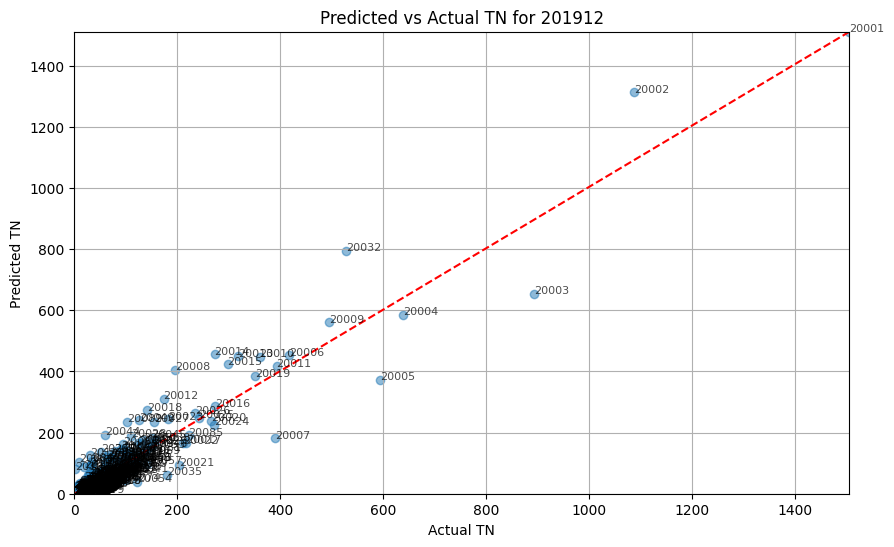

In [33]:
# Scatter plot of tn_pred vs tn_actual with product_id as the dot label
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(result['tn_actual'], result['tn_pred'], alpha=0.5)
plt.title('Predicted vs Actual TN for 201912')
plt.xlabel('Actual TN')
plt.ylabel('Predicted TN')
plt.plot([0, result['tn_actual'].max()], [0, result['tn_pred'].max()], color='red', linestyle='--')  # Diagonal line
for i, txt in enumerate(result['product_id']):
    plt.annotate(txt, (result['tn_actual'].iloc[i], result['tn_pred'].iloc[i]), fontsize=8, alpha=0.7)
plt.xlim(0, result['tn_actual'].max())
plt.ylim(0, result['tn_pred'].max())
plt.grid()
plt.show()

In [6]:
import polars as pl
# Read the CSV from Data
df = pl.read_csv('../data/kaggle_submission_202002_regresion.csv')

In [7]:
#Scale all the 'tn' values by 0.90 and save it as kaggle_submission_090.csv
df = df.with_columns(
    (pl.col('tn') * 1.02).alias('tn')
)  
# Save the modified DataFrame to a new CSV file
df.write_csv('../data/kaggle_submission_regresion_102.csv')